In [1]:
pip install --upgrade matplotlib #make sure matplotlib is 3.4+ to use ax.bar_label

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 2.1 MB/s 
     |████████████████████████████████| 959 kB 44.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import xgboost as xgb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from keras.activations import sigmoid

In [16]:
df = pd.read_csv('/content/drive/MyDrive/league_data.csv')
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

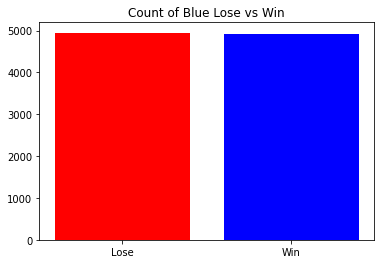

In [4]:
# our label is roughly equal so there is no class imbalance
win_count = df['blueWins'].value_counts()
plt.bar(x=['Lose','Win'],height=win_count,color=['red','blue'])
plt.title('Count of Blue Lose vs Win');

In [5]:
win = df.loc[df['blueWins']==1].drop(labels=['gameId','blueWins'],axis=1)
lose = df.loc[df['blueWins']==0].drop(labels=['gameId','blueWins'],axis=1)

In [6]:
win.iloc[:,0]

5       18
6       18
9       13
12      18
14      15
        ..
9872    12
9873    18
9874    17
9875    54
9878    18
Name: blueWardsPlaced, Length: 4930, dtype: int64

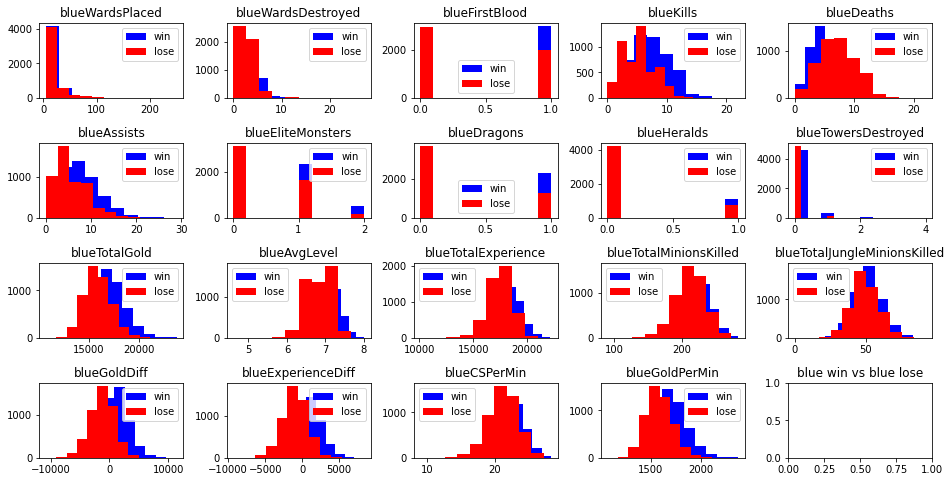

In [ ]:
#plot histograms to compare stats when blue win to stats when blue loses
#useful to see the difference between win and lose

fig, ax = plt.subplots(4,5,figsize=(16, 8))

for r in range(4):
  for j in range(5):
    col = r*5 + j
    if col == 19:
      continue
    ax[r,j].hist(win.iloc[:,col],label='win',color='blue')
    # ax[r,j].set_title(win.columns[col])

for r in range(4):
  for j in range(5):
    col = r*5 + j
    if col == 19:
      continue
    ax[r,j].hist(lose.iloc[:,col],label='lose',color='red')
    ax[r,j].set_title(win.columns[col])
    ax[r,j].legend()

# ax[0,0].legend()
ax[3,4].set_title('blue win vs blue lose')
fig.subplots_adjust(hspace=0.6, wspace=0.3)

From the histograms, it seems like blueWardsPlaced, blueWardsDestroyed, blueHeralds, blueTotalMinionsKilled, and blueCSPerMin don't really change depending on blue win or lose.

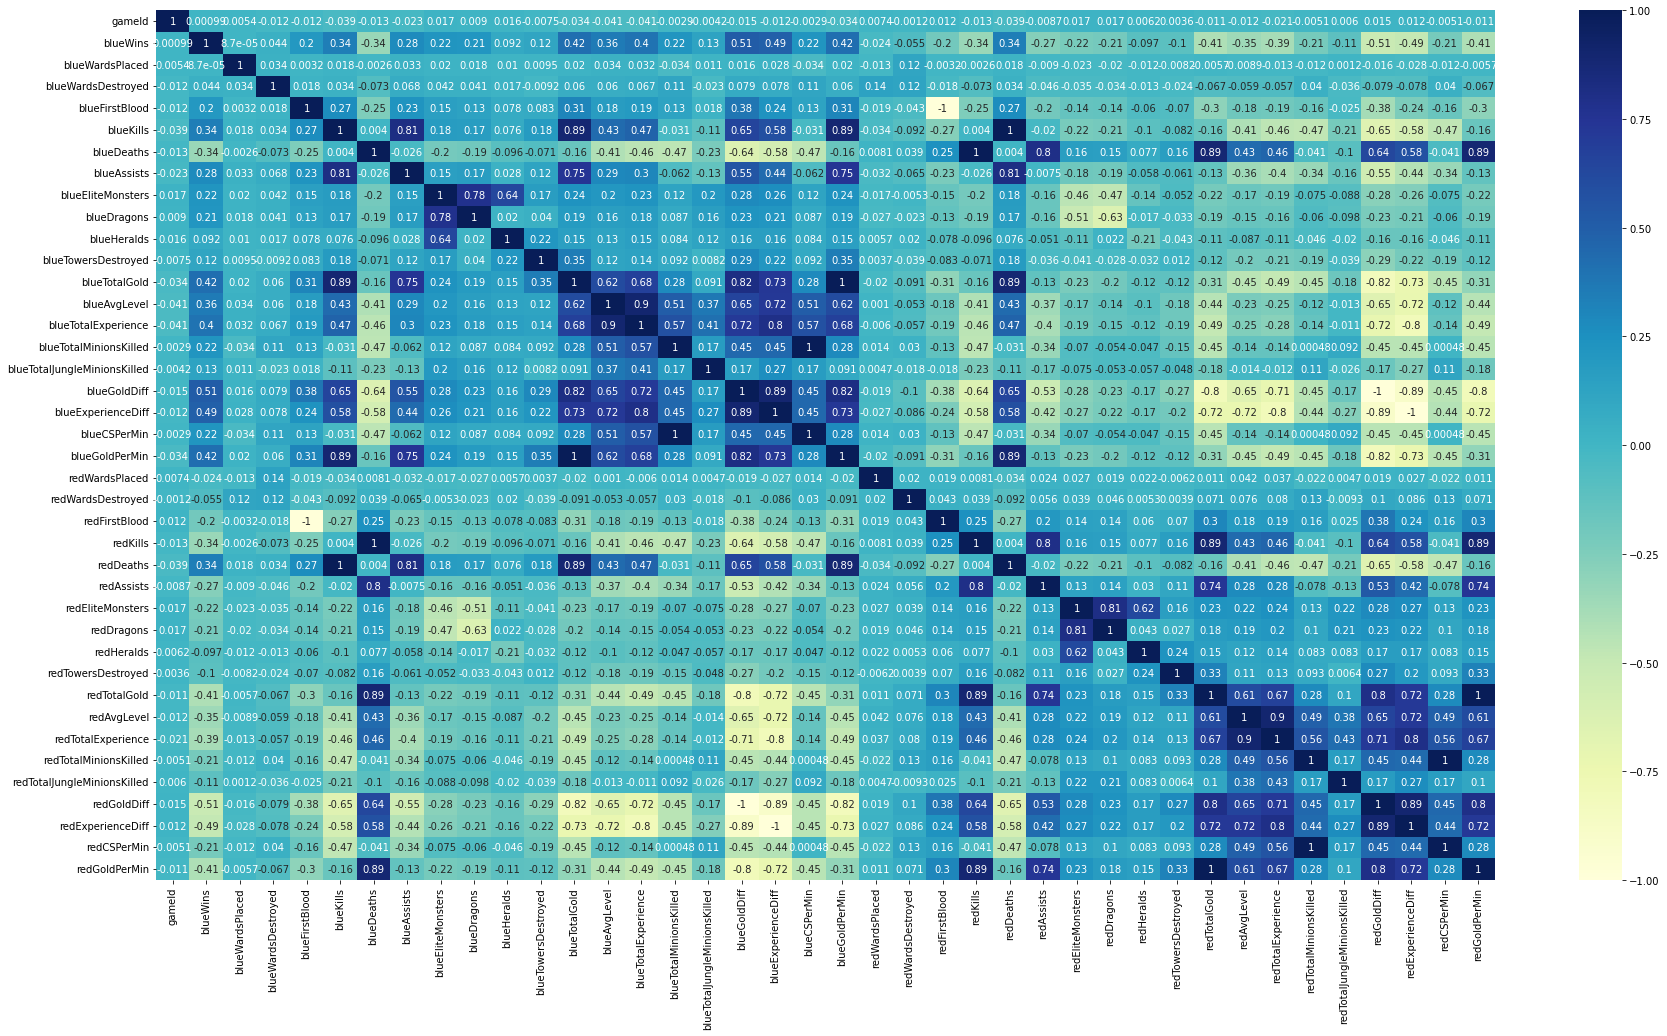

In [7]:
plt.figure(figsize = (30,16))
sns.heatmap(df.corr(),cmap="YlGnBu",annot=True);

Seems like the correlated variables are mostly from the last few variables on the x-axis in the heatmap. This make sense since those variables are related to the red team's progress which are captured in the blue team's variables. For example, redDeaths and redKills would be captured by blueKills and blueDeaths respectively.

In [ ]:
#some correlated columns to remove
remove = ['gameId','redTotalGold','redAvgLevel','redTotalExperience','redGoldDiff','redExperienceDiff','redGoldPerMin','redDeaths','redKills']
df_removed = df.copy()
df_removed.drop(labels=remove,axis=1,inplace=True)

In [17]:
def bar(df, group_col, avg_col, x_label=None, y_label=None, title=None, xticklabels=['Lost','Won'], fsize=(8,7),ylim=None):
  '''
  makes a bar plot to see the average of avg_col grouped by group_col
  '''
  assert isinstance(group_col,str)
  assert isinstance(avg_col,str)

  fig, ax = plt.subplots(figsize=fsize)
  sns.barplot(data=df,x=group_col, y=avg_col, palette='cool_r', ax=ax, ci=68)

  ax.set_xticklabels(xticklabels)
  if x_label:
    ax.set_xlabel(x_label)
  if y_label:
    ax.set_ylabel(y_label)
  if title:
    ax.set_title(title);
  if ylim:
    ax.set_ylim(ylim)
  ax.bar_label(ax.containers[0],padding=6);

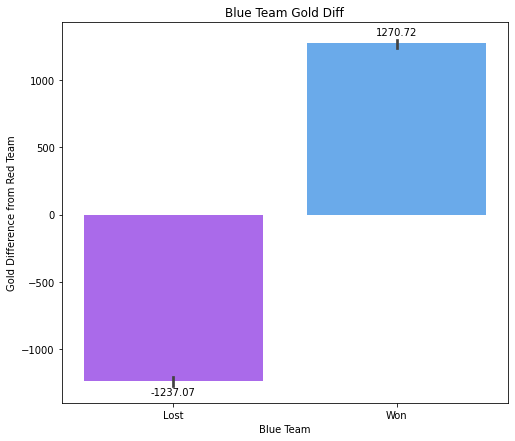

In [ ]:
bar(df,'blueWins','blueGoldDiff',x_label='Blue Team',y_label='Gold Difference from Red Team',title='Blue Team Gold Diff')

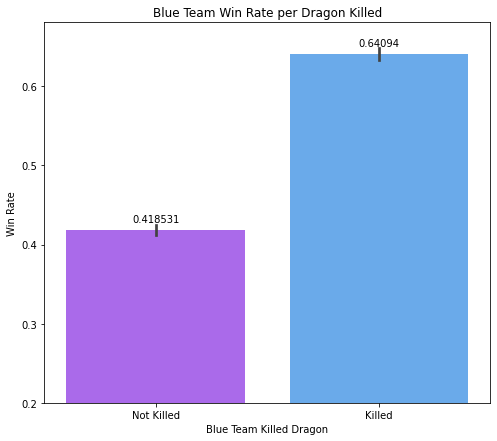

In [ ]:
bar(df,group_col='blueDragons',avg_col='blueWins',
    x_label='Blue Team Killed Dragon',y_label='Win Rate',
    xticklabels=['Not Killed','Killed'],title='Blue Team Win Rate per Dragon Killed',
    ylim=[0.2,None])

In [ ]:
df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

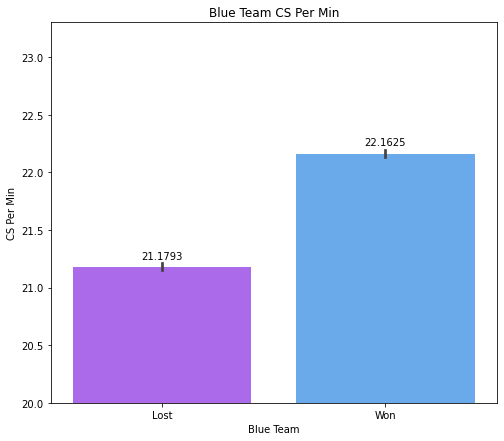

In [ ]:
bar(df,group_col='blueWins',avg_col='blueCSPerMin',
    x_label='Blue Team',y_label='CS Per Min',
    title='Blue Team CS Per Min', ylim=[20,None])

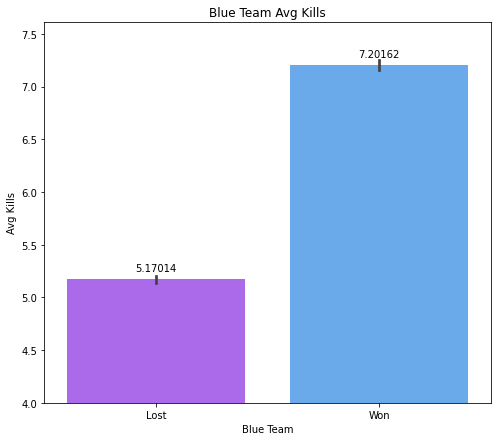

In [ ]:
bar(df,group_col='blueWins',avg_col='blueKills',
    x_label='Blue Team',y_label='Avg Kills',
    title='Blue Team Avg Kills',ylim=[4,None])

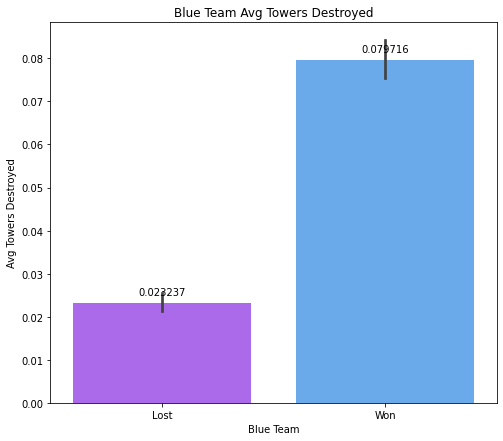

In [ ]:
#from the graph below, we can see that it's not common to destroy a tower before 10min but it seems to help in winning
bar(df,group_col='blueWins',avg_col='blueTowersDestroyed',
    x_label='Blue Team',y_label='Avg Towers Destroyed',
    title='Blue Team Avg Towers Destroyed')

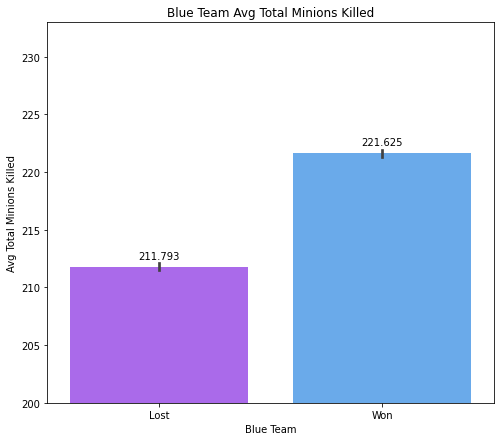

In [ ]:
bar(df,group_col='blueWins',avg_col='blueTotalMinionsKilled',
    x_label='Blue Team',y_label='Avg Total Minions Killed',
    title='Blue Team Avg Total Minions Killed',ylim=[200,None])

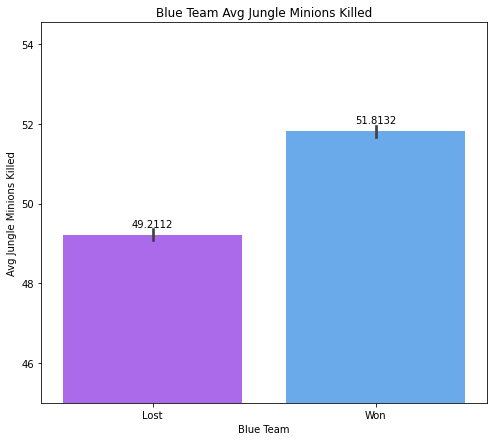

In [ ]:
bar(df,group_col='blueWins',avg_col='blueTotalJungleMinionsKilled',
    x_label='Blue Team',y_label='Avg Jungle Minions Killed',
    title='Blue Team Avg Jungle Minions Killed',ylim=[45,None])

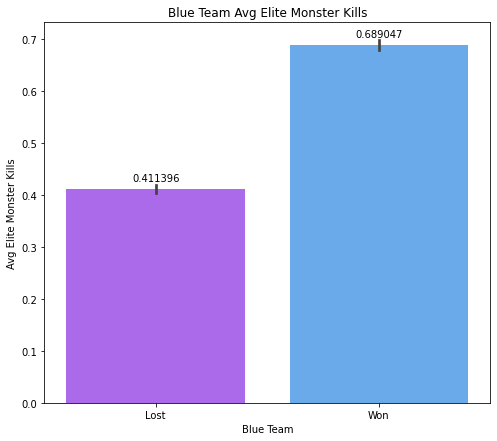

In [18]:
bar(df,group_col='blueWins',avg_col='blueEliteMonsters',
    x_label='Blue Team',y_label='Avg Elite Monster Kills',
    title='Blue Team Avg Elite Monster Kills')

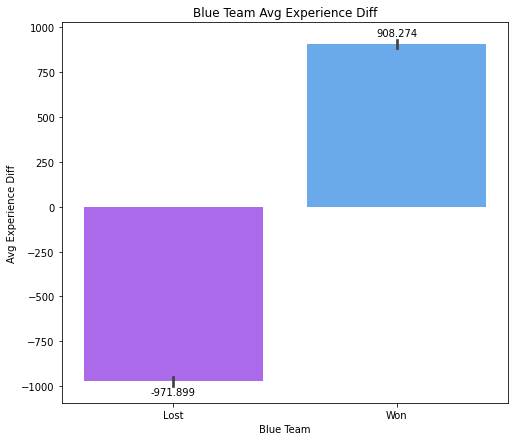

In [19]:
bar(df,group_col='blueWins',avg_col='blueExperienceDiff',
    x_label='Blue Team',y_label='Avg Experience Diff',
    title='Blue Team Avg Experience Diff')

# Compare Blue and Red differences

Let's take a look at how Red team performed when Blue team won and vice versa

In [ ]:
def plot_blueVSred(df, blue_col, red_col, x_label=None, y_label=None, title=None, fsize=(12,4)):
  '''
  makes a bar plot of average of blue_col and red_col so that we can visualize how blue team did compared to red team
  in 2 scenarios: blue team won and blue team lost
  
  Args:
    df (pandas df): dataframe containing the data
    blue_col (str): blue column data to use
    red_col (str): red column data to use
    bluewin (bool): specifies if we want to compare blue win vs red loss (True) or blue loss vs red win (False)
  '''
  assert isinstance(blue_col,str)
  assert isinstance(red_col,str)

  fig = plt.figure(figsize=fsize)
  gs = GridSpec(nrows=1,ncols=2)
  bw = df.groupby('blueWins')[blue_col].mean()[1]
  rl = df.groupby('blueWins')[red_col].mean()[1]
  bl = df.groupby('blueWins')[blue_col].mean()[0]
  rw = df.groupby('blueWins')[red_col].mean()[0]

  ax0 = fig.add_subplot(gs[0,0])
  ax1 = fig.add_subplot(gs[0,1])

  ax0.bar(x=[blue_col,red_col], height=[bw,rl],color=['blue','red'])
  ax0.set_title('Stats for Blue Win vs Red Loss')
  ax0.bar_label(ax0.containers[0],padding=0);
  if x_label:
    ax0.set_xlabel(x_label)
    ax1.set_xlabel(x_label)
  if y_label:
    ax0.set_ylabel(y_label)
    ax1.set_ylabel(y_label)

  ax1.bar(x=[blue_col,red_col], height=[bl,rw],color=['blue','red'])
  ax1.set_title('Stats for Blue Loss vs Red Win')
  ax1.bar_label(ax1.containers[0],padding=0)

  print(f'When Blue Team won: Blue Team did {(bw/rl)*100:.2f}% better than Red Team')
  print(f'When Blue Team lost: Red Team did {(rw/bl)*100:.2f}% better than Blue Team')

When Blue Team won: Blue Team did 108.00% better than Red Team
When Blue Team lost: Red Team did 107.80% better than Blue Team


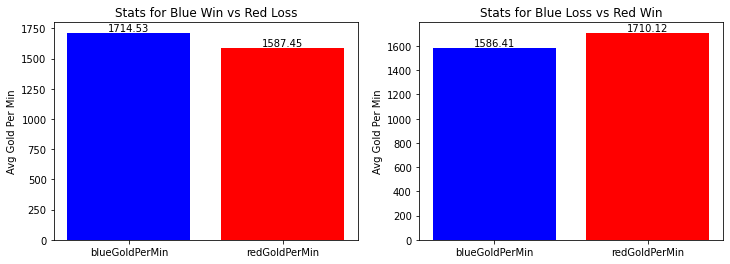

In [ ]:
#On average, if Blue gets 8% more Gold/min (200) than Red then Blue is more likely to win
plot_blueVSred(df,'blueGoldPerMin','redGoldPerMin',y_label='Avg Gold Per Min')

When Blue Team won: Blue Team did 104.20% better than Red Team
When Blue Team lost: Red Team did 104.81% better than Blue Team


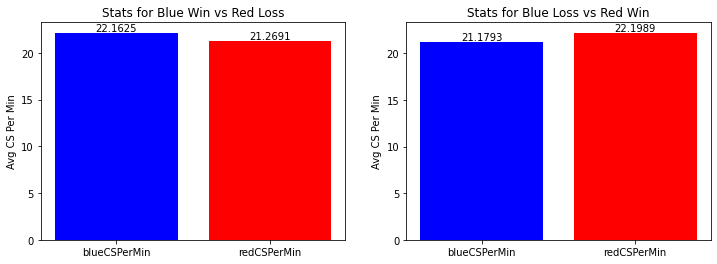

In [ ]:
#not much of a difference in CS per min that would tell us if Blue would win
plot_blueVSred(df,'blueCSPerMin','redCSPerMin',y_label='Avg CS Per Min')

When Blue Team won: Blue Team did 389.11% better than Red Team
When Blue Team lost: Red Team did 281.74% better than Blue Team


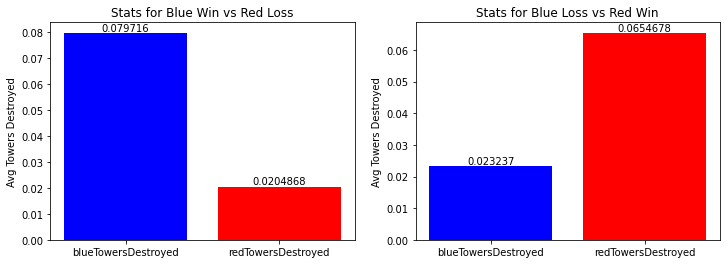

In [ ]:
#it's not common to take the first tower in the first 10 minutes but seems like the team that takes a tower is more likely to win
plot_blueVSred(df,'blueTowersDestroyed','redTowersDestroyed',y_label='Avg Towers Destroyed')

When Blue Team won: Blue Team did 104.20% better than Red Team
When Blue Team lost: Red Team did 104.81% better than Blue Team


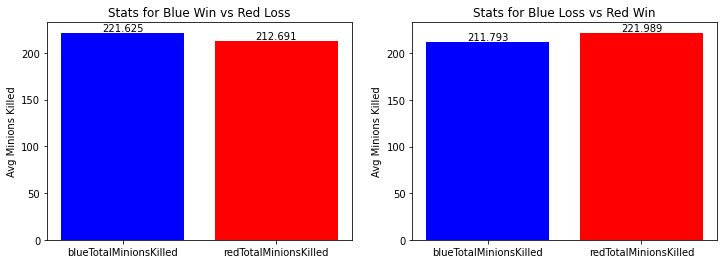

In [ ]:
#There doesn't seem to be much of a difference in minions killed in the first 10 minutes to determine if Blue won
plot_blueVSred(df,'blueTotalMinionsKilled','redTotalMinionsKilled',y_label='Avg Minions Killed')

When Blue Team won: Blue Team did 103.22% better than Red Team
When Blue Team lost: Red Team did 106.53% better than Blue Team


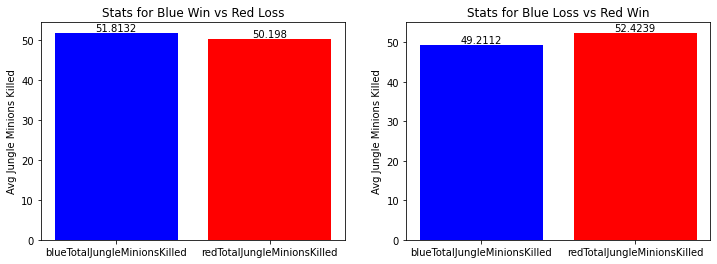

In [ ]:
plot_blueVSred(df,'blueTotalJungleMinionsKilled','redTotalJungleMinionsKilled',y_label='Avg Jungle Minions Killed')

# Modeling

In [ ]:
def evaluate_model(model, xtrain, xtest, ytrain, ytest):
  ytrain_pred = model.predict(xtrain)
  ytest_pred = model.predict(xtest)

  print('###### Classification Report for Training Data ######')
  print(metrics.classification_report(ytrain, ytrain_pred))

  print('###### Classification Report for Test Data ######')
  print(metrics.classification_report(ytest, ytest_pred))

  print('###### Confusion Matrix and ROC Curves ######')
  fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(9,6))
  plt.subplots_adjust(wspace=0.5,hspace=0.5)
  metrics.ConfusionMatrixDisplay.from_predictions(ytrain, ytrain_pred,ax=ax[0,0],display_labels=['lose','win'],colorbar=False,normalize='true')
  metrics.ConfusionMatrixDisplay.from_predictions(ytest, ytest_pred,ax=ax[0,1],display_labels=['lose','win'],colorbar=False,normalize='true')
  #'normalize' gets the accuracy over rows. ie for true label row 'lose', it normalizes over that row
  ax[0,0].set_title('Training Data')
  ax[0,1].set_title('Test Data')

  metrics.RocCurveDisplay.from_predictions(ytrain,ytrain_pred,ax=ax[1,0],name='Train')
  metrics.RocCurveDisplay.from_predictions(ytest,ytest_pred,ax=ax[1,1],name='Test')
  ax[1,0].plot([0,1],[0,1],ls='-')
  ax[1,0].grid()
  ax[1,0].set_title('ROC Curve - Train')
  ax[1,1].plot([0,1],[0,1],ls='-')
  ax[1,1].grid()
  ax[1,1].set_title('ROC Curve - Test')

### Logistic Regression Model

In [ ]:
X = df_removed.drop(labels=['blueWins'],axis=1)
y = df_removed['blueWins'].copy()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=10,shuffle=True)

In [ ]:
logreg_l2 = LogisticRegressionCV(cv=5,penalty='l2',max_iter=1000)
logreg_l2.fit(x_train,y_train)

LogisticRegressionCV(cv=5, max_iter=1000)

###### Classification Report for Training Data ######
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      4445
           1       0.73      0.73      0.73      4446

    accuracy                           0.73      8891
   macro avg       0.73      0.73      0.73      8891
weighted avg       0.73      0.73      0.73      8891

###### Classification Report for Test Data ######
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       504
           1       0.71      0.71      0.71       484

    accuracy                           0.72       988
   macro avg       0.72      0.72      0.72       988
weighted avg       0.72      0.72      0.72       988

###### Confusion Matrix and ROC Curves ######


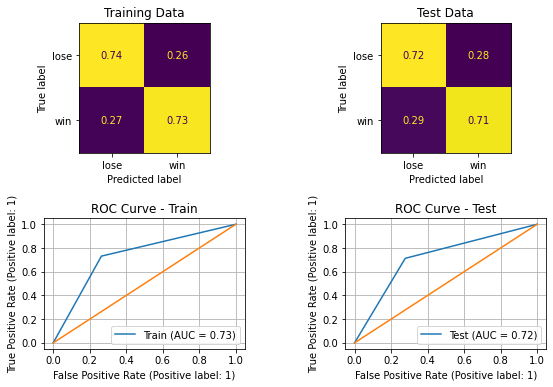

In [ ]:
evaluate_model(logreg_l2,x_train,x_test,y_train,y_test)

###### Classification Report for Training Data ######
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4445
           1       0.73      0.73      0.73      4446

    accuracy                           0.73      8891
   macro avg       0.73      0.73      0.73      8891
weighted avg       0.73      0.73      0.73      8891

###### Classification Report for Test Data ######
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       504
           1       0.70      0.69      0.70       484

    accuracy                           0.70       988
   macro avg       0.70      0.70      0.70       988
weighted avg       0.70      0.70      0.70       988

###### Confusion Matrix and ROC Curves ######


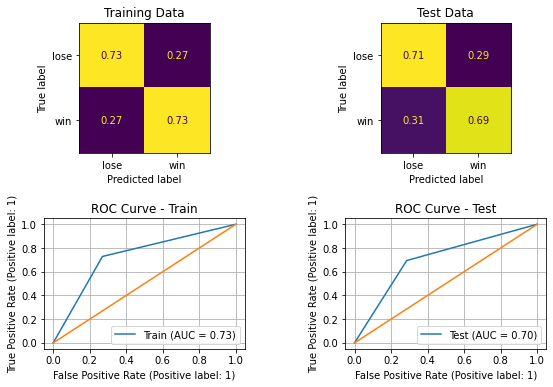

In [ ]:
#when using logistic regression on the whole df, the results are slightly worse than df_removed
X = df.drop(labels=['blueWins'],axis=1)
y = df_removed['blueWins'].copy()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=10,shuffle=True)

logreg_l2_full = LogisticRegressionCV(cv=5,penalty='l2',solver='lbfgs',max_iter=500)
logreg_l2_full.fit(x_train,y_train)

evaluate_model(logreg_l2_full,x_train,x_test,y_train,y_test)

### XGBoost

In [ ]:
X = df_removed.drop(labels=['blueWins'],axis=1)
y = df_removed['blueWins'].copy()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=10,shuffle=True)

In [ ]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train,y_train)

XGBClassifier()

###### Classification Report for Training Data ######
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      4445
           1       0.75      0.74      0.75      4446

    accuracy                           0.75      8891
   macro avg       0.75      0.75      0.75      8891
weighted avg       0.75      0.75      0.75      8891

###### Classification Report for Test Data ######
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       504
           1       0.72      0.69      0.70       484

    accuracy                           0.71       988
   macro avg       0.71      0.71      0.71       988
weighted avg       0.71      0.71      0.71       988

###### Confusion Matrix and ROC Curves ######


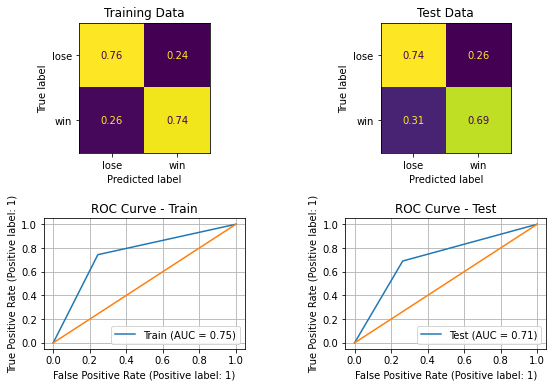

In [ ]:
evaluate_model(xgb_classifier,x_train,x_test,y_train,y_test)

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=10,)
params = {'max_depth':[3,4,5,6],
          'learning_rate':[0.03,0.06,0.2],
          'min_child_weight':[1,2,3],
          }
xgb_search = GridSearchCV(estimator=xgb_clf,param_grid=params,cv=5,verbose=1,scoring='f1')
xgb_search.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=XGBClassifier(random_state=10),
             param_grid={'learning_rate': [0.03, 0.06, 0.2],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [1, 2, 3]},
             scoring='f1', verbose=1)

In [ ]:
xgb_search.best_params_

{'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 2}

###### Classification Report for Training Data ######
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      4445
           1       0.74      0.73      0.74      4446

    accuracy                           0.74      8891
   macro avg       0.74      0.74      0.74      8891
weighted avg       0.74      0.74      0.74      8891

###### Classification Report for Test Data ######
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       504
           1       0.71      0.70      0.71       484

    accuracy                           0.71       988
   macro avg       0.71      0.71      0.71       988
weighted avg       0.71      0.71      0.71       988

###### Confusion Matrix and ROC Curves ######


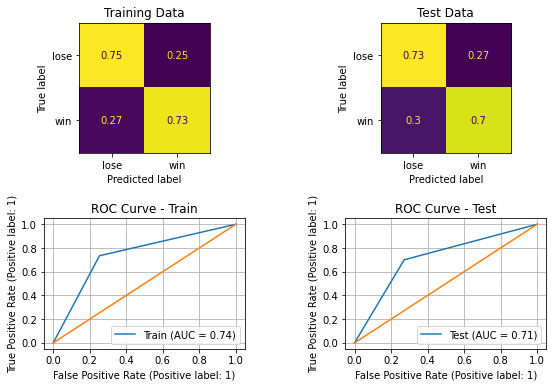

In [ ]:
xgb_best = xgb.XGBClassifier(random_state=10,learning_rate=0.03,max_depth=3,min_child_weight=2)
xgb_best.fit(x_train,y_train)
evaluate_model(xgb_best,x_train,x_test,y_train,y_test)

### Visualizing Feature Importances

In [ ]:
# Extract the importance of each feature used in xgboost
xgb_importance = pd.Series(xgb_best.feature_importances_,
               index=x_train.columns).sort_values(ascending=False)
xgb_importance

blueGoldDiff                    0.454278
blueExperienceDiff              0.131660
redDragons                      0.047683
blueDragons                     0.041052
redEliteMonsters                0.040123
blueEliteMonsters               0.036956
blueTotalExperience             0.028730
blueTotalJungleMinionsKilled    0.026941
blueDeaths                      0.026611
redAssists                      0.026242
redTotalMinionsKilled           0.022972
blueTotalGold                   0.022324
redTotalJungleMinionsKilled     0.021631
redWardsDestroyed               0.018175
blueTotalMinionsKilled          0.016642
redWardsPlaced                  0.015652
blueAssists                     0.010877
blueWardsPlaced                 0.009824
blueHeralds                     0.001626
blueGoldPerMin                  0.000000
blueCSPerMin                    0.000000
blueWardsDestroyed              0.000000
redFirstBlood                   0.000000
blueAvgLevel                    0.000000
blueTowersDestro

Text(0, 0.5, 'Feature')

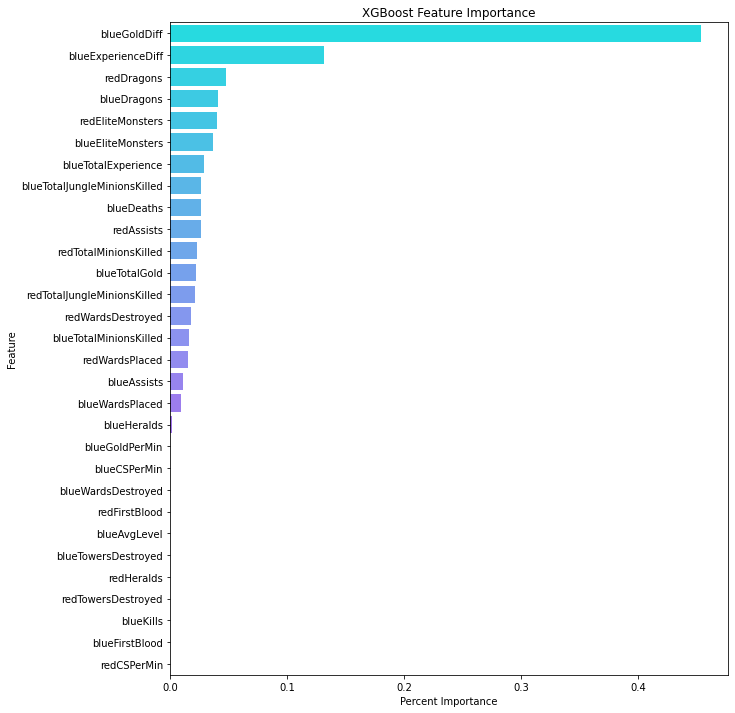

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(x=xgb_importance.values, y=xgb_importance.index, palette='cool',orient='h',ax=ax)
ax.set_title('XGBoost Feature Importance')
ax.set_xlabel('Percent Importance')
ax.set_ylabel('Feature')

In [ ]:
#Extract the importance of each coefficient used for logistic regression
logreg_importance = pd.Series(logreg_l2.coef_.flatten(),index=x_train.columns).sort_values(ascending=False)
logreg_importance

blueEliteMonsters               0.063431
blueDragons                     0.062824
blueKills                       0.013500
blueFirstBlood                  0.013419
redTowersDestroyed              0.006043
blueTotalJungleMinionsKilled    0.005997
blueWardsDestroyed              0.003049
redTotalMinionsKilled           0.001842
redTotalJungleMinionsKilled     0.001046
blueHeralds                     0.000608
blueGoldDiff                    0.000390
blueExperienceDiff              0.000259
redCSPerMin                     0.000184
blueTotalGold                   0.000026
blueGoldPerMin                  0.000003
blueTotalExperience            -0.000035
blueCSPerMin                   -0.000172
blueAvgLevel                   -0.000852
blueTotalMinionsKilled         -0.001719
blueWardsPlaced                -0.002063
redWardsPlaced                 -0.002124
blueTowersDestroyed            -0.003052
redAssists                     -0.004339
redHeralds                     -0.005424
blueAssists     

Text(0, 0.5, 'Element of Game')

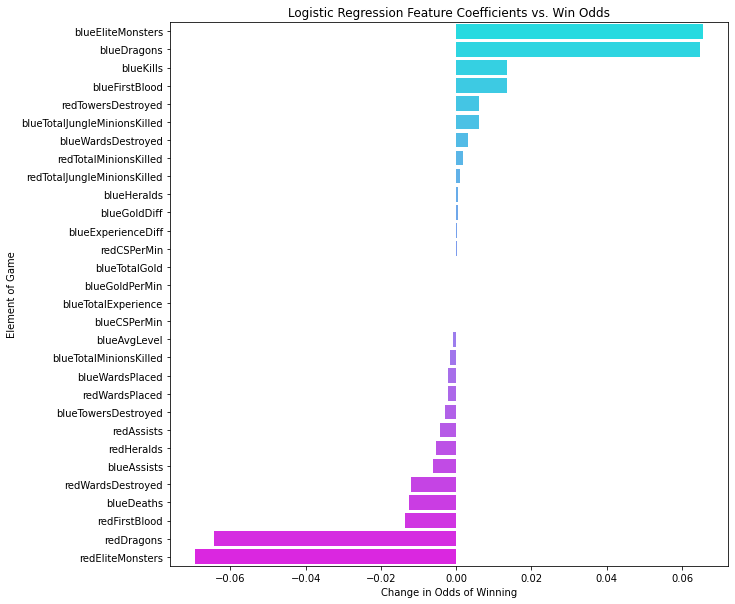

In [ ]:
# Convert log coefficients to odds and subtract 1 to display change in odds.
log_odds = np.exp(logreg_importance) - 1

# Create bar plot of feature coefficients as odds.
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x=log_odds.values, y=log_odds.index, palette='cool', ax=ax, orient='h')

ax.set_title('Logistic Regression Feature Coefficients vs. Win Odds')
ax.set_xlabel('Change in Odds of Winning')
ax.set_ylabel('Element of Game')

'''
some interesting notes: 
  - for each redTotalMinionsKilled, the odds of blue winning increases and for each blueTotalMinionsKilled, the odds decrease.
  - the same goes for TowersDestroyed.
  - for each blueAssist, the odds decrease.
'''

When Blue Team won: Blue Team did 108.00% better than Red Team
When Blue Team lost: Red Team did 107.80% better than Blue Team


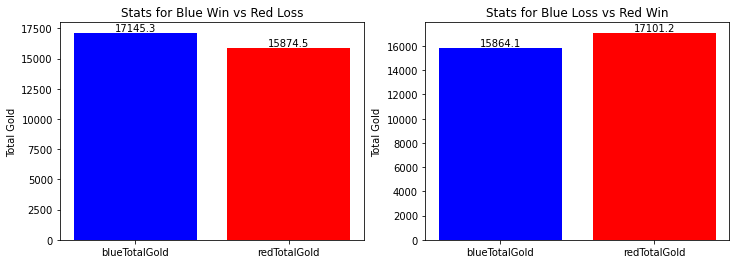

In [ ]:
plot_blueVSred(df,'blueTotalGold','redTotalGold',y_label='Total Gold')

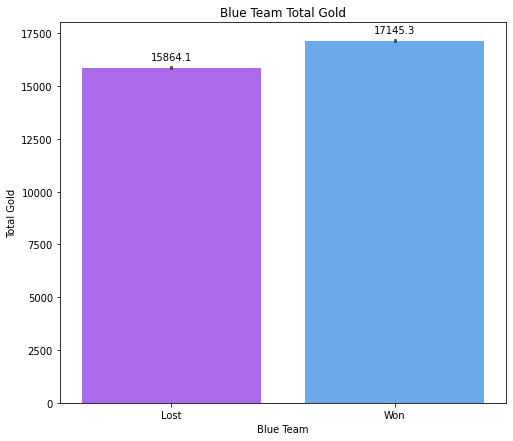

In [ ]:
bar(df,'blueWins','blueTotalGold',x_label='Blue Team',y_label='Total Gold',title='Blue Team Total Gold')

When Blue Team won: Blue Team did 104.20% better than Red Team
When Blue Team lost: Red Team did 104.81% better than Blue Team


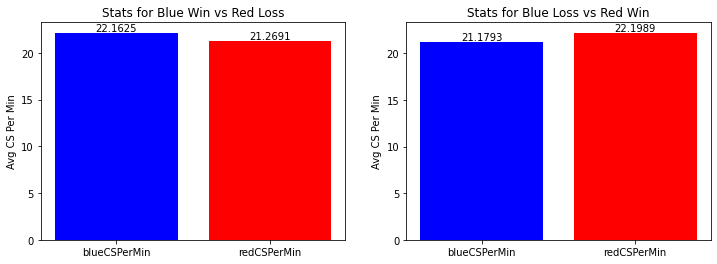

In [ ]:
plot_blueVSred(df,'blueCSPerMin','redCSPerMin',y_label='Avg CS Per Min')

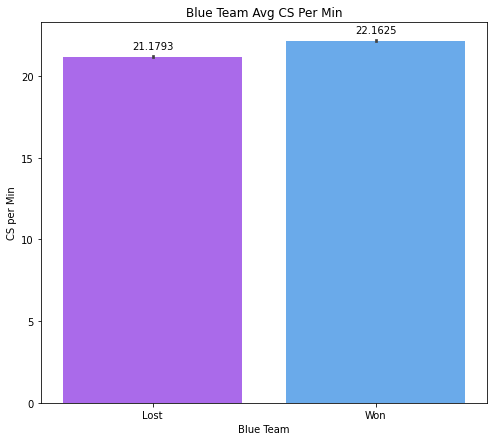

In [ ]:
bar(df,'blueWins','blueCSPerMin',x_label='Blue Team',y_label='CS per Min',title='Blue Team Avg CS Per Min')

# XGBoost Model on Original Data

###### Classification Report for Training Data ######
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      4445
           1       0.74      0.73      0.74      4446

    accuracy                           0.74      8891
   macro avg       0.74      0.74      0.74      8891
weighted avg       0.74      0.74      0.74      8891

###### Classification Report for Test Data ######
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       504
           1       0.71      0.70      0.71       484

    accuracy                           0.72       988
   macro avg       0.72      0.72      0.72       988
weighted avg       0.72      0.72      0.72       988

###### Confusion Matrix and ROC Curves ######


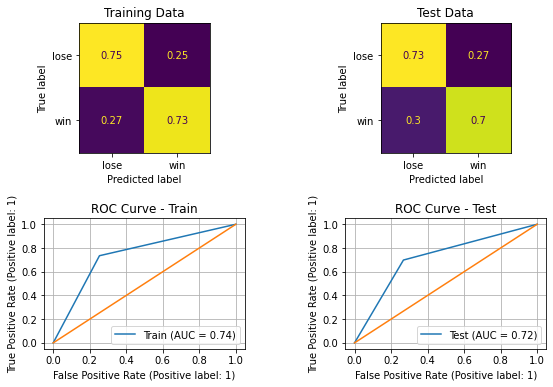

In [ ]:
X = df.drop(labels=['blueWins','gameId'],axis=1)
y = df['blueWins'].copy()

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=10,shuffle=True)

xgb_best = xgb.XGBClassifier(random_state=10,learning_rate=0.03,max_depth=3,min_child_weight=2)
xgb_best.fit(x_train,y_train)
evaluate_model(xgb_best,x_train,x_test,y_train,y_test)

Text(0, 0.5, 'Feature')

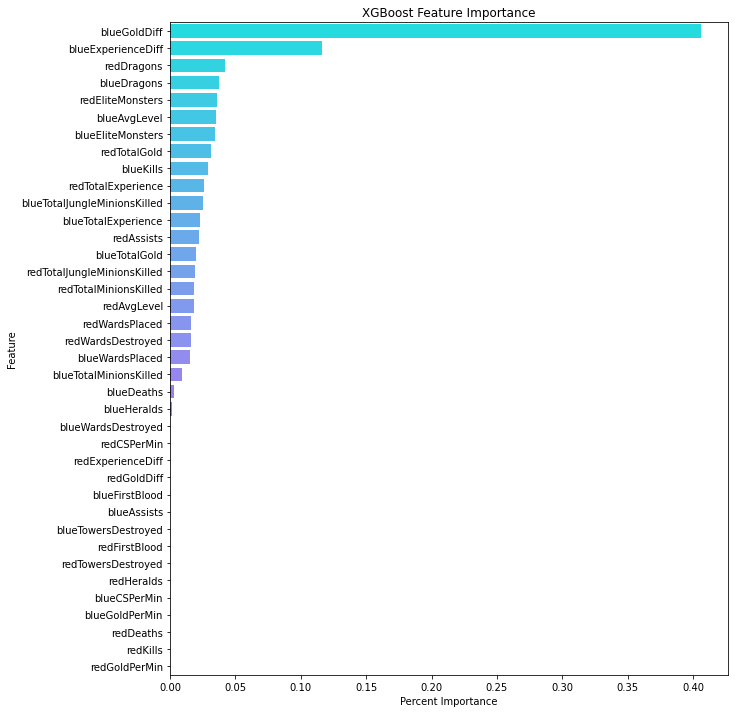

In [ ]:
xgb_importance = pd.Series(xgb_best.feature_importances_,
               index=x_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(x=xgb_importance.values, y=xgb_importance.index, palette='cool',orient='h',ax=ax)
ax.set_title('XGBoost Feature Importance')
ax.set_xlabel('Percent Importance')
ax.set_ylabel('Feature')

# XGBoost on More Selective Columns

In [ ]:
remove = ['gameId','redTotalGold','redAvgLevel','redTotalExperience','redGoldDiff','redExperienceDiff','redGoldPerMin','redDeaths','redKills'] #columns we previously removed
remove += ['blueGoldPerMin','blueCSPerMin','blueAvgLevel','redCSPerMin','blueTotalExperience','redFirstBlood'] #extra variables to remove after looking at feature importances

In [ ]:
df_removed2 = df.drop(labels=remove,axis=1)
X = df_removed2.drop(labels=['blueWins'],axis=1)
y = df_removed2['blueWins'].copy()
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=10,shuffle=True)

In [ ]:
##### scale the inputs. Didn't make much of a difference for xgboost. Made more difference for logistic regression.
# scaler = StandardScaler()
# cols = x_train.columns
# x_train = pd.DataFrame(scaler.fit_transform(x_train),columns=cols)
# x_test = pd.DataFrame(scaler.transform(x_test),columns=cols)

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=10,)
params = {'max_depth':[3,4,5,6],
          'learning_rate':[0.03,0.06,0.2],
          'min_child_weight':[1,2,3],
          }
xgb_search = GridSearchCV(estimator=xgb_clf,param_grid=params,cv=5,verbose=1,scoring='f1')
xgb_search.fit(x_train,y_train)

print(xgb_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 1}


###### Classification Report for Training Data ######
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      4445
           1       0.74      0.73      0.74      4446

    accuracy                           0.74      8891
   macro avg       0.74      0.74      0.74      8891
weighted avg       0.74      0.74      0.74      8891

###### Classification Report for Test Data ######
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       504
           1       0.71      0.70      0.71       484

    accuracy                           0.71       988
   macro avg       0.71      0.71      0.71       988
weighted avg       0.71      0.71      0.71       988

###### Confusion Matrix and ROC Curves ######


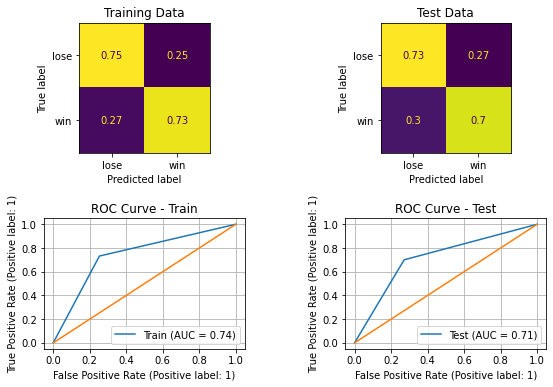

In [ ]:
xgb_best = xgb.XGBClassifier(random_state=10,learning_rate=0.03,max_depth=3,min_child_weight=1)
xgb_best.fit(x_train,y_train)
evaluate_model(xgb_best,x_train,x_test,y_train,y_test)

Text(0, 0.5, 'Feature')

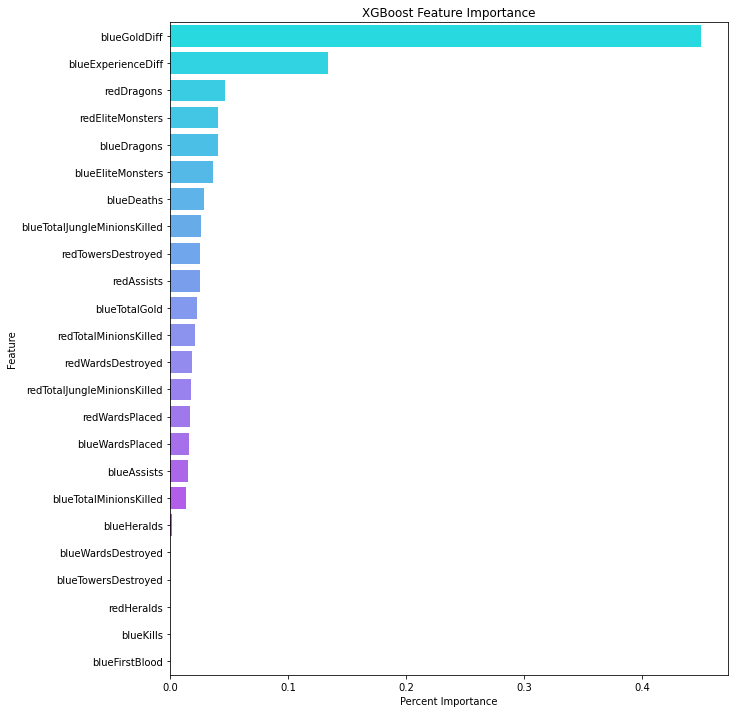

In [ ]:
xgb_importance = pd.Series(xgb_best.feature_importances_,
               index=x_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(x=xgb_importance.values, y=xgb_importance.index, palette='cool',orient='h',ax=ax)
ax.set_title('XGBoost Feature Importance')
ax.set_xlabel('Percent Importance')
ax.set_ylabel('Feature')

# Logistic Regression on More Selective Columns

###### Classification Report for Training Data ######
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4445
           1       0.74      0.73      0.74      4446

    accuracy                           0.74      8891
   macro avg       0.74      0.74      0.74      8891
weighted avg       0.74      0.74      0.74      8891

###### Classification Report for Test Data ######
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       504
           1       0.71      0.71      0.71       484

    accuracy                           0.72       988
   macro avg       0.72      0.72      0.72       988
weighted avg       0.72      0.72      0.72       988

###### Confusion Matrix and ROC Curves ######


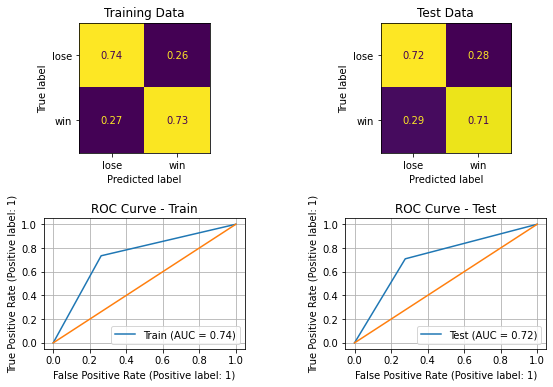

In [ ]:
logreg_l2 = LogisticRegressionCV(cv=5,penalty='l2',max_iter=1000)
logreg_l2.fit(x_train,y_train)
evaluate_model(logreg_l2,x_train,x_test,y_train,y_test)

Text(0, 0.5, 'Element of Game')

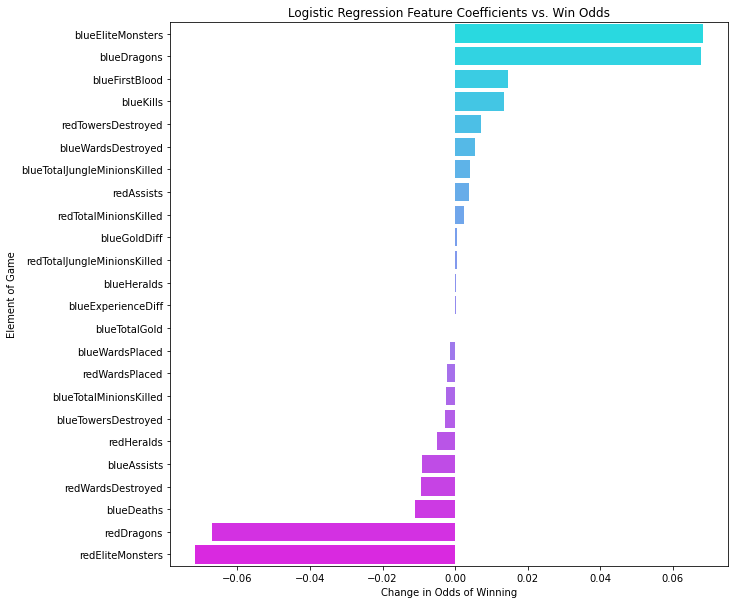

In [ ]:
logreg_importance = pd.Series(logreg_l2.coef_.flatten(),index=x_train.columns).sort_values(ascending=False)

log_odds = np.exp(logreg_importance) - 1

# Create bar plot of feature coefficients as odds.
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x=log_odds.values, y=log_odds.index, palette='cool', ax=ax, orient='h')

ax.set_title('Logistic Regression Feature Coefficients vs. Win Odds')
ax.set_xlabel('Change in Odds of Winning')
ax.set_ylabel('Element of Game')

### logistic regression with scaled inputs

It seems like goldDiff becomes a bigger factor

###### Classification Report for Training Data ######
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      4445
           1       0.74      0.73      0.73      4446

    accuracy                           0.73      8891
   macro avg       0.73      0.73      0.73      8891
weighted avg       0.73      0.73      0.73      8891

###### Classification Report for Test Data ######
              precision    recall  f1-score   support

           0       0.72      0.73      0.73       504
           1       0.72      0.70      0.71       484

    accuracy                           0.72       988
   macro avg       0.72      0.72      0.72       988
weighted avg       0.72      0.72      0.72       988

###### Confusion Matrix and ROC Curves ######


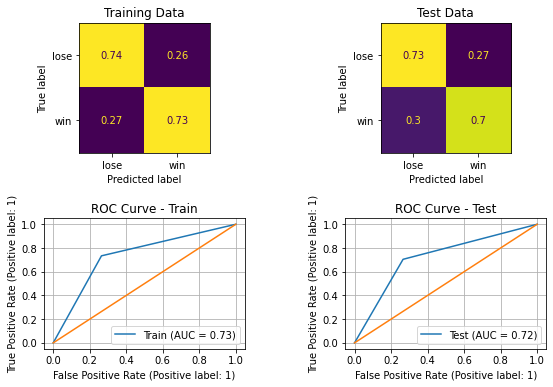

In [ ]:
logreg_l2 = LogisticRegressionCV(cv=5,penalty='l2',max_iter=1000)
logreg_l2.fit(x_train,y_train)
evaluate_model(logreg_l2,x_train,x_test,y_train,y_test)

Text(0, 0.5, 'Element of Game')

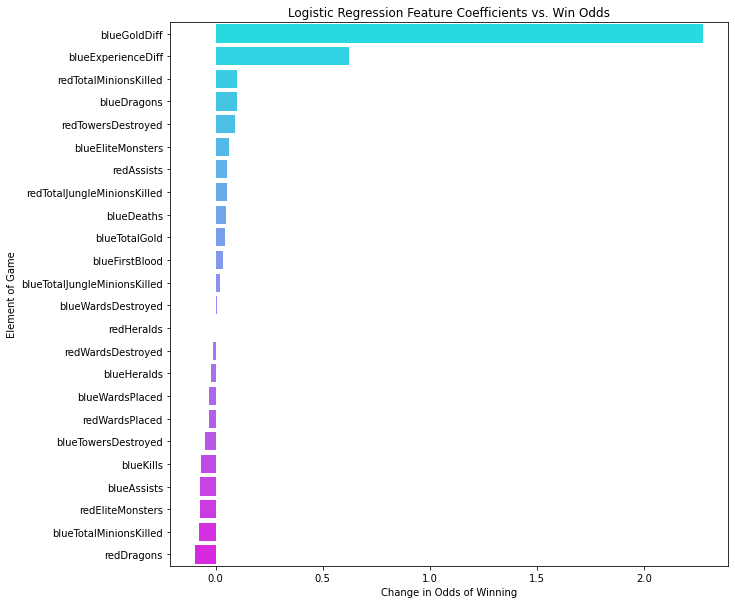

In [ ]:
logreg_importance = pd.Series(logreg_l2.coef_.flatten(),index=x_train.columns).sort_values(ascending=False)

log_odds = np.exp(logreg_importance) - 1

# Create bar plot of feature coefficients as odds.
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x=log_odds.values, y=log_odds.index, palette='cool', ax=ax, orient='h')

ax.set_title('Logistic Regression Feature Coefficients vs. Win Odds')
ax.set_xlabel('Change in Odds of Winning')
ax.set_ylabel('Element of Game')

# Neural Network

In [ ]:
X = df.drop(labels=['gameId','blueWins'],axis=1)
y = df['blueWins'].copy()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=10,shuffle=True)

In [ ]:
scaler = StandardScaler()
cols = x_train.columns
x_train = pd.DataFrame(scaler.fit_transform(x_train),columns=cols)
x_test = pd.DataFrame(scaler.transform(x_test),columns=cols)

In [ ]:
model = Sequential()
model.add(tf.keras.Input(shape=(X.shape[1],)))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.4))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.4))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.4))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.4))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.4))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.4))

model.add(Dense(16))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.4))

model.add(Dense(8))
model.add(BatchNormalization())
model.add(LeakyReLU())
# model.add(Dropout(0.4))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Recall(),'accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-3 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 4 epochs"
        patience=4,
        verbose=1,
    )
]

In [ ]:
model.fit(x_train,y_train,epochs=40,batch_size=32, validation_split=0.1, verbose=1, callbacks = callbacks)

Epoch 1/40
251/251 [==============================] - 7s 10ms/step - loss: 0.6500 - recall_9: 0.6494 - accuracy: 0.6227 - val_loss: 0.5487 - val_recall_9: 0.6095 - val_accuracy: 0.7157
Epoch 2/40
251/251 [==============================] - 2s 8ms/step - loss: 0.5795 - recall_9: 0.6600 - accuracy: 0.7044 - val_loss: 0.5433 - val_recall_9: 0.6377 - val_accuracy: 0.7169
Epoch 3/40
251/251 [==============================] - 2s 8ms/step - loss: 0.5698 - recall_9: 0.6991 - accuracy: 0.7185 - val_loss: 0.5345 - val_recall_9: 0.6725 - val_accuracy: 0.7213
Epoch 4/40
251/251 [==============================] - 2s 8ms/step - loss: 0.5630 - recall_9: 0.7129 - accuracy: 0.7184 - val_loss: 0.5323 - val_recall_9: 0.6746 - val_accuracy: 0.7292
Epoch 5/40
251/251 [==============================] - 2s 8ms/step - loss: 0.5592 - recall_9: 0.7021 - accuracy: 0.7210 - val_loss: 0.5302 - val_recall_9: 0.6811 - val_accuracy: 0.7247
Epoch 6/40
251/251 [==============================] - 2s 8ms/step - loss: 0.554

In [ ]:
score = model.evaluate(x_test,y_test,verbose=1)
print(score)

31/31 [==============================] - 0s 3ms/step - loss: 0.5471 - recall_9: 0.7190 - accuracy: 0.7206
[0.5470992922782898, 0.7190082669258118, 0.7206477522850037]
